Neuromorphic engineering I

## Lab 5: Static Circuits: Transconductance Amplifier

Team member 1: Quillan Favey 

Group number: 

Date: 10.25.22

-------------------------------------------------------------------------------------------------------------------

### Lab objectives

The objectives of this lab are to understand and characterize one of the most important circuit in analog IC design.

The experimental objectives are as follows:
1. To characterize a simple differential transconductance amplifier and understand its operation in terms of the behavior of the differential pair and the current mirror. Specifically, to understand the dependence of the output current on the differential input voltages.
2. To characterize single-stage 2-transistor “common-source” amplifier gain, and how it arises from transconductance and output impedance.

# 1 Prelab

## 1.1 Transconductance amplifier

* Now consider a simple differential transconductance amplifier which is built from a
differential pair and a current mirror. The output current should be equal to the the
difference of the two differential pair currents, i. e. $I_{out} = I_1 - I_2$. Is this statement
true? Justify your answer by stating your assumptions about transistor saturation and
drain conductance.

Yes, as long as all MOSFETs are in saturation ($V_s>4U_T$) and the diff. pair is operated below threshold. This restricts our output voltage range to:

\begin{equation}
V_s+4U_T<V_{OUT}<V_{dd}-4U_T
\end{equation}


If we have a look at the case where $V_1=V_2$, the current flowing through each branch will be $\frac{I_b}{2}$
The drain conductance ($g_{md}=\frac{-\delta I_{out}}{\delta V_{out}}$) in these conditions (saturation, subthreshold and assuming $V_E$ is the same for every MOSFET) can be written as:
$
\begin{align}
    g_{md}=g_{ds}=\frac{I_4}{V_E}+\frac{I_2}{V_E} \\
    g_{ds}=\frac{I_b}{2V_E}+\frac{I_b}{2V_E} \\
    g_{ds}=\frac{I_b}{V_E}\\
\end{align}
$

Where $V_E$ is the early voltage. 

Also by appyling KCL we can verify this statement
.

* Now consider the transconductance amplifier with the output open-circuited
  (i.e. no current flows into or out of the output node). Say $V_2$ is fixed
  at some voltage in the middle of the rails, e.g., $\frac{Vdd}{2}$. Explain what happens to the
  output voltage as $V_1$ is swept from below $V_2$ to
  above $V_2$ for a subthreshold bias. Discuss the current through the
  differential pair transistors and the current mirror, and the voltage on
  the internal node common to the differential pair transistors.  Try to keep
  the discussion concise.


The equation for $V_{out}$ in a transconductance amplifier is the following:

\begin{align}
V_{out} = A(V_1-V_2)
\end{align}

In subthreshold,

\begin{align}
A \approx \frac{\kappa V_E}{2U_T}
\end{align}

* For V1<V2:

    $I_2$ is equal to $I_b$ and $I_1$ is 0, therefore the current in the current mirror is also 0. Which will lead to a discharge in the "node capacitor" and the M2 NFET voltage will drop to 0 and as M2 goes out of saturation, $V_{out}\approx V_s$.

* For V1>V2:

    $I_1$ is equal to $I_b$ and $I_2$ is 0, therefore the current in the mirror is $I_b$ which will lead to charging of the "node capacitor" and eventually M5 will go out of saturation as $V_{out}$ will go up to Vdd.

* What is the transconductance $g_m = \dfrac{\mathrm{d} I_{out}}{\mathrm{d} V_{in}}$, where
  $V_{in} \equiv V_1 - V_2$, in sub-threshold? How does it change if
  the circuit is operated super-threshold?


> In sub-threshold: $g_m = \frac{I_b \kappa}{2U_T}$

> In super-threshold: $g_m = \sqrt{\beta I_b}$ for $|V_1-V_2|<\sqrt{2I_b/\beta}$

* Quantitatively, what is the relationship between transconductance, output
  resistance $r_o$, and voltage gain $A$ of a transconductance amplifier?


\begin{align}
    &gd = \frac{Ib}{V_E} \\
   & r_o=\frac{1}{g_d}=\frac{V_E}{I_b}\\
    &A = \frac{dV_{out}}{d(v_1-V_2)}=\frac{dI_{out}}{d(v_1-V_2)}\frac{dV_{out}}{dI_{out}}=\frac{g_m}{g_d}=g_{m}r_o=\frac{I_b \kappa}{2U_T}r_o


\end{align}

## 1.2 Wide-Range Transamp

* Draw the schematic of a wide-range transconductance amplifier and explain why it
does not have the simple 5-transistor transamp restriction on allowable output voltage.
You can either draw the schematic directly on the Jupyter notebook using the _schemdraw_ , or sketch it with pen and paper and paste a picture in a Markdown cell.

![](image.png.png)

> The current mirror transistors, in order be in saturation need a $V_g$ that is lower than $V_{dd}-4U_T$ so $V_s$ must satisfy this condition as well. $V_s$ must also keep M3 in saturation and must therefore be greater than $4U_T$. We end up with $I_1$ charging the "capacitor node" at $I_{out}$ and $I_2$ discharging it. And the only boundary on Vout is then $4U_T$

# 2 Setup

## 2.1 Connect the device

In [1]:
# import the necessary library to communicate with the hardware
import pyplane

import time
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
# create a Plane object and open the communication
if 'p' not in locals():
    p = pyplane.Plane()
    try:
        p.open('/dev/ttyACM0')
    except RuntimeError as e:
        del p
        print(e)

In [3]:
p.get_firmware_version()

(1, 8, 6)

In [4]:
# Send a reset signal to the board, check if the LED blinks
p.reset(pyplane.ResetType.Soft)

time.sleep(0.5) 
# NOTE: You must send this request events every time you do a reset operetion, otherwise the recieved data is noisy.
# Because the class chip need to do handshake to get the communication correct.
p.request_events(1)

In [5]:
# Try to read something, make sure the chip responses
p.read_current(pyplane.AdcChannel.GO0_N)

8.862304667900389e-08

In [6]:
# If any of the above steps fail, delete the object, and restart the kernel

# del p

## 2.2 Setup C2F and voltage output buffer

In [6]:
# setup C2F
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_HYS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 100)])

time.sleep(0.2) 
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_BIAS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

time.sleep(0.2)
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_PWLK_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

time.sleep(0.2)
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_REF_L, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 255)])

time.sleep(0.2)
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.C2F_REF_H, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 255)])

time.sleep(0.2)
# setup output rail-to-rail buffer
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.RR_BIAS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

# 3 N-Type 5T Transamp

## 3.0 Schematic and pin map

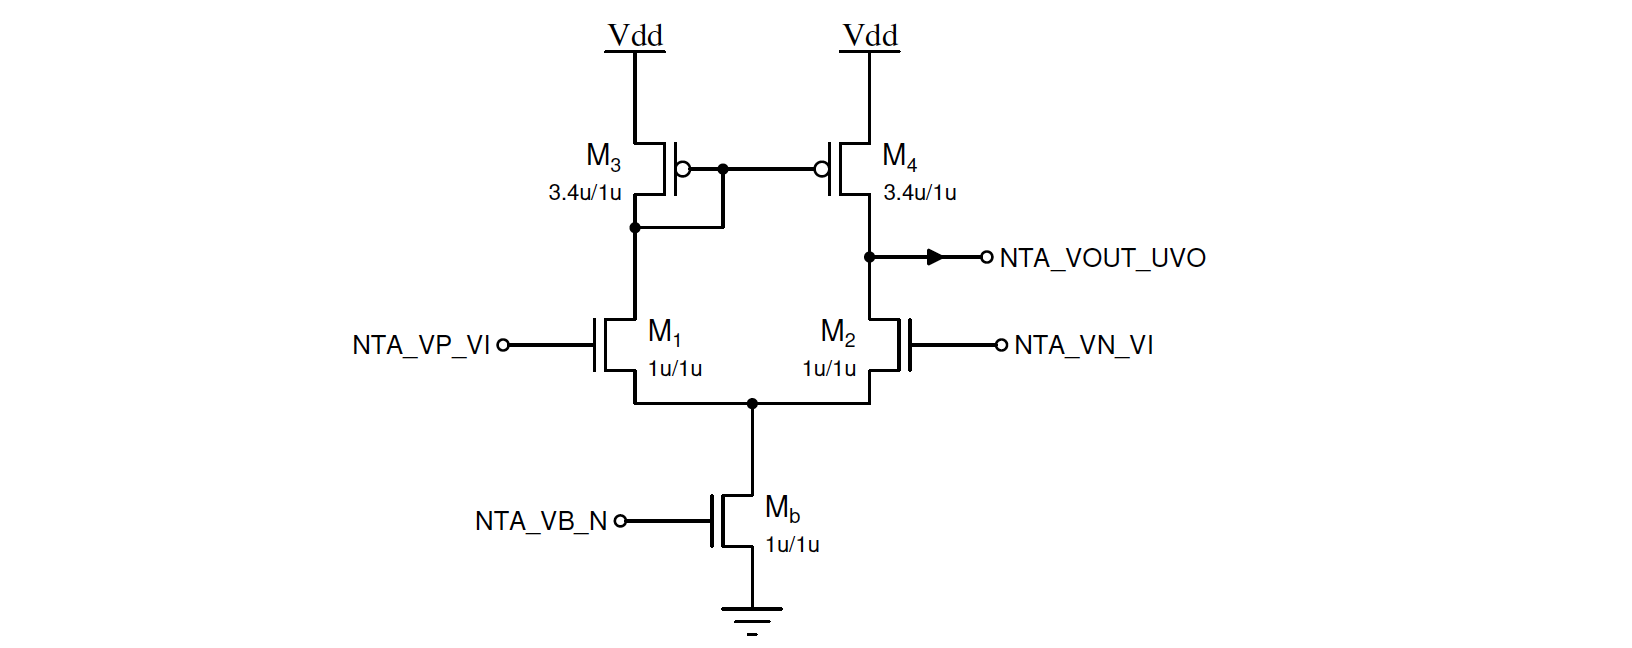

**$V_1$ = $V_p$ = NTA_VP_VI = AIN3**

**$V_2$ = $V_n$ = NTA_VN_VI = AIN4**

**$V_{out}$ = NTA_VOUT_UVO = ADC[13]**

**$I_{out}$ = $I_+ - I_-$ = NTA_IOUT_UO - NTA_IOUT_UBO = C2F[11] - C2F[12]**;   **Note that $I_+$ and $I_-$ is not $I_1$ and $I_2$.**

**Note: There are three identical NTA circuits with the same bias and input voltages, one with the output open-circuited and routed out at NTA_VOUT_UVO, the other two with $V_{out}$ fixed to 1V but $I_{out}$ routed out through N- and P- type current mirror at NTA_IOUT_UO and NTA_IOUT_UBO.**

## 3.1 Chip configuration

In [7]:
# configure N type TransAmp
p.send_coach_events([pyplane.Coach.generate_aerc_event( \
    pyplane.Coach.CurrentOutputSelect.SelectLine5, \
    pyplane.Coach.VoltageOutputSelect.SelectLine1, \
    pyplane.Coach.VoltageInputSelect.SelectLine2, \
    pyplane.Coach.SynapseSelect.NoneSelected, 0)])

## 3.2 Calibration of C2F channels

Here you need to calibrate NTA_IOUT_UO and NTA_IOUT_UBO in the same way as the last lab

### 3.2.1 NTA_IOUT_UO

* Set fixed voltages for $V_1$ and $V_2$

In [11]:
p.set_voltage(pyplane.DacChannel.AIN3,0.8) # V1 = 0.8
time.sleep(0.2) # settle time
p.set_voltage(pyplane.DacChannel.AIN4,0.2) # V2 = 0.2 

0.19882699847221375

Set voltages such that $V_1\gg V_2$.

* Data aquisition (Hint: use master current for $I_b$ = 30 nA)

In [12]:
import numpy as np
import time

calIout_UO_ex3 = np.arange(0,85,1) # bias current sweep range, fine value

c2f_Iout_UO_ex3 = []  # what you get is frequency

for n in range(len(calIout_UO_ex3)):
    
    # set bias
    p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, calIout_UO_ex3[n])])
    
    time.sleep(0.2) # settle time
    
    # read c2f values 
    c2f_Iout_UO_ex3_temp = p.read_c2f_output(0.1) 
    c2f_Iout_UO_ex3.append(c2f_Iout_UO_ex3_temp[11])
    
print(c2f_Iout_UO_ex3)


[4, 128, 249, 372, 479, 599, 714, 831, 911, 1029, 1140, 1255, 1353, 1465, 1575, 1686, 1694, 1806, 1906, 2020, 2112, 2215, 2325, 2428, 2498, 2606, 2705, 2802, 2915, 3008, 3100, 3207, 3130, 3232, 3338, 3433, 3531, 3638, 3722, 3821, 3909, 3977, 4076, 4160, 4242, 4380, 4476, 4536, 4547, 4633, 4726, 4818, 4959, 4996, 5084, 5197, 5238, 5324, 5412, 5514, 5598, 5681, 5765, 5859, 5775, 5724, 5820, 5899, 5982, 6062, 6196, 6219, 6292, 6369, 6456, 6687, 6761, 6853, 7013, 7020, 7058, 7193, 7197, 7295, 7363]


* Plot

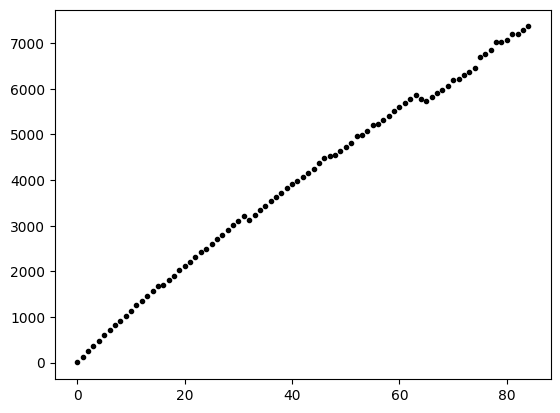

In [13]:
plt.plot(c2f_Iout_UO_ex3, '.k')
plt.show()

* Save data

In [14]:
# if the data looks nice, save it!
data_Iout_UO_ex3_cal= [c2f_Iout_UO_ex3, calIout_UO_ex3]
# save to csv file
np.savetxt('./data/c2f_Iout_UO_ex3_cal.csv', data_Iout_UO_ex3_cal, delimiter=',')

* Load data you saved

In [15]:
# load the saved data
c2f_Iout_UO_ex3_save,calIout_UO_ex3_save = np.loadtxt('./data/c2f_Iout_UO_ex3_cal.csv',  delimiter=',') 

* C2f plot

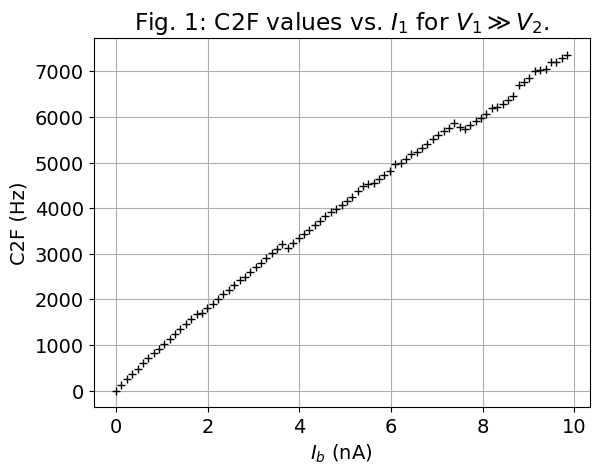

In [16]:
# C2f plot
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 14})

Iout_UO_ex3 = calIout_UO_ex3_save/256*30 

plt.plot(Iout_UO_ex3,c2f_Iout_UO_ex3_save,'k+')

plt.xlabel('$I_b$ (nA)')
plt.ylabel('C2F (Hz)')
# plt.legend(['C2F'],prop={'size': 14})
plt.title('Fig. 1: C2F values vs. $I_1$ for $V_1 \gg V_2$.')
plt.grid()
plt.show()

Fig. 1 shows the C2F values obtained by sweeping the bias current over the range $I_b \in [0\text{nA},10\text{nA}]$, whereas $V_1 = 0.8\text{V}$ and $V_2 = 0.2\text{V}$. 

The values for $V_1$ and $V_2$ were chosen such that $V_1 \gg V_2$. For these values, the corresponding currents becomes $I_1 \approx I_b$ and $I_2 \approx 0$. The measured data can therefore be utilized to determine the mapping between $I_1 \approx I_b$ and the C2F measurements for the transconductance amplifier.

* Extract the function $I_+\left(f_+\right)$ (Hint: use higher order polynomial to increase accuracy)

The I1(f1) function of NTA_IOUT_UO is :
           2
4.409e-08 x + 0.001044 x - 0.06894


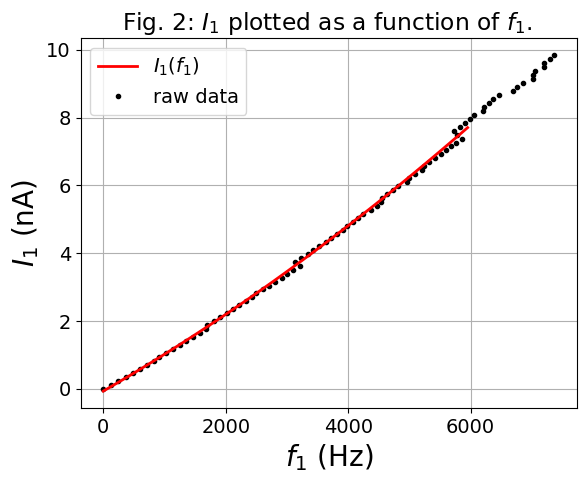

In [17]:
# plot the raw data
raw_UO, = plt.plot(c2f_Iout_UO_ex3_save, Iout_UO_ex3, '.k') 

# data range you want to fit
low_bound = 2  
high_bound = 80
# print(c2f_Iout_UO_ex3[low_bound:high_bound])

# fit polynomial to C2F (frequency) vs I data
a2, a1, a0 = np.polyfit(c2f_Iout_UO_ex3_save[low_bound:high_bound], Iout_UO_ex3[low_bound:high_bound],2)
# print(a0)
# print(a1)
# print(a2)

# Print out the function I(f) you got
I_freq = np.polyfit(c2f_Iout_UO_ex3_save[low_bound:high_bound], Iout_UO_ex3[low_bound:high_bound], 2)
print ('The I1(f1) function of NTA_IOUT_UO is :')
print (np.poly1d(I_freq))


# select frequency range that you want to plot
freq = np.arange(0, 6000, 50) 
# print(freq)

I1 = a2*freq**2 + a1*freq + a0   # function I(f), 
fit, = plt.plot(freq, I1, 'r-', linewidth=2) 


plt.xlabel('$f_1$ (Hz)', {'size':20})
plt.ylabel('$I_1$ (nA)', {'size':20})
plt.legend([fit, raw_UO], ['$I_1(f_1)$', 'raw data'],prop={'size': 14})
plt.title('Fig. 2: $I_1$ plotted as a function of $f_1$. ')
plt.grid()
plt.show()

### 3.2.2 NTA_IOUT_UBO

* Set fixed voltages for $V_1$ and $V_2$

In [16]:
p.set_voltage(pyplane.DacChannel.AIN3,0.2) # V1 = 0.8
time.sleep(0.2) # settle time
p.set_voltage(pyplane.DacChannel.AIN4,0.8) # V2 = 0.2 

0.798827052116394

Set voltages such that $V_1\ll V_2$.

* Data aquisition (Hint: use master current for $I_b$ 30 nA)

In [18]:
import numpy as np
import time

calIout_UBO_ex3 = np.arange(0,85,1) # bias current sweep range

c2f_Iout_UBO_ex3 = []

for n in range(len(calIout_UBO_ex3)):
    
    # set bias
    p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, calIout_UBO_ex3[n])])
    
    time.sleep(0.2) # settle time
    
    # read c2f values 
    c2f_Iout_UBO_ex3_temp = p.read_c2f_output(0.1) 
    c2f_Iout_UBO_ex3.append(c2f_Iout_UBO_ex3_temp[12])
    
print(c2f_Iout_UBO_ex3)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


* Plot

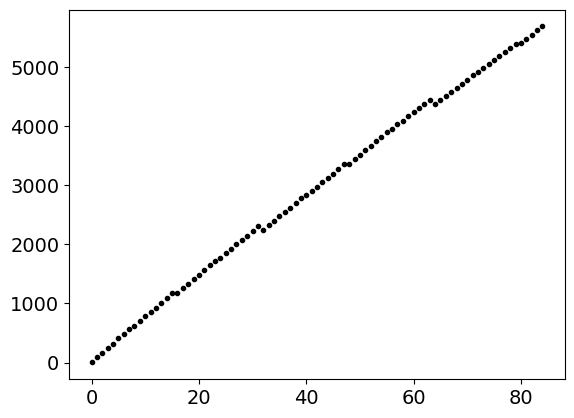

In [18]:
plt.plot(c2f_Iout_UBO_ex3, '.k')
plt.show()

* Save data

In [19]:
# if the data looks nice, save it!
data_Iout_UBO_ex3_cal= [c2f_Iout_UBO_ex3, calIout_UBO_ex3]
# save to csv file
np.savetxt('./data/c2f_Iout_UBO_ex3_cal.csv', data_Iout_UBO_ex3_cal, delimiter=',')

* Load data you saved

In [19]:
# load the saved data
c2f_Iout_UBO_ex3_save,calIout_UBO_ex3_save = np.loadtxt('./data/c2f_Iout_UBO_ex3_cal.csv',  delimiter=',') 

* C2F plot

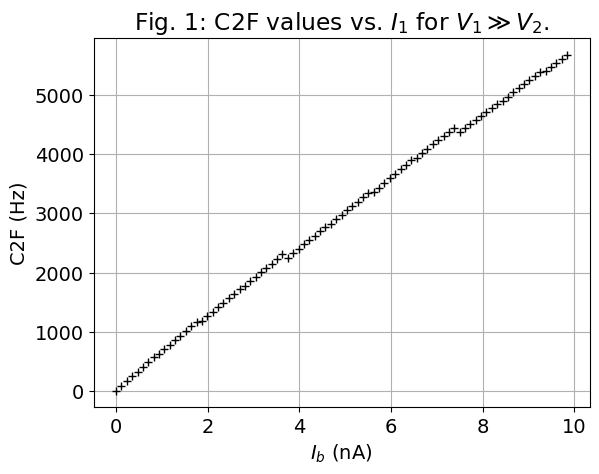

In [20]:
# C2f plot
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 14})

Iout_UBO_ex3 = calIout_UBO_ex3_save/256*30 

plt.plot(Iout_UBO_ex3,c2f_Iout_UBO_ex3_save,'k+')

plt.xlabel('$I_b$ (nA)')
plt.ylabel('C2F (Hz)')
# plt.legend(['C2F'],prop={'size': 14})
plt.title('Fig. 1: C2F values vs. $I_1$ for $V_1 \gg V_2$.')
plt.grid()
plt.show()

* Extract the function $I_-\left(f_-\right)$ (Hint: use second-order polynomial to increase accuracy)

The I1(f1) function of NTA_IOUT_UO is :
           2
2.977e-08 x + 0.001575 x - 0.06453


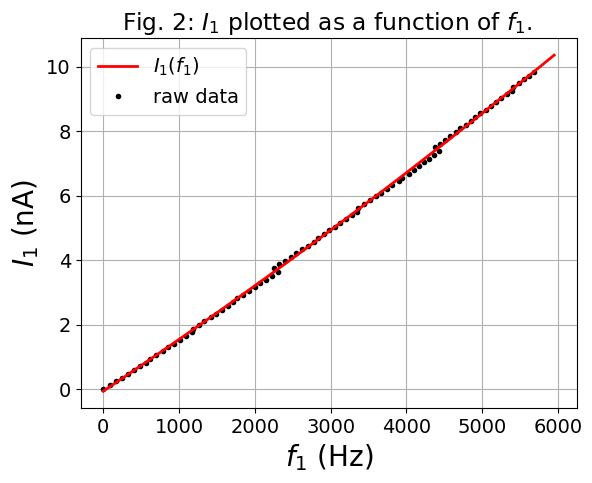

In [21]:
# plot the raw data
raw_UO, = plt.plot(c2f_Iout_UBO_ex3_save, Iout_UBO_ex3, '.k') 

# data range you want to fit
low_bound = 2  
high_bound = 80
# print(c2f_Iout_UO_ex3[low_bound:high_bound])

# fit polynomial to C2F (frequency) vs I data
a2, a1, a0 = np.polyfit(c2f_Iout_UBO_ex3_save[low_bound:high_bound], Iout_UBO_ex3[low_bound:high_bound],2)
# print(a0)
# print(a1)
# print(a2)

# Print out the function I(f) you got
I_freq = np.polyfit(c2f_Iout_UBO_ex3_save[low_bound:high_bound], Iout_UBO_ex3[low_bound:high_bound], 2)
print ('The I1(f1) function of NTA_IOUT_UO is :')
print (np.poly1d(I_freq))


# select frequency range that you want to plot
freq = np.arange(0, 6000, 50) 
# print(freq)

I1 = a2*freq**2 + a1*freq + a0   # function I(f), 
fit, = plt.plot(freq, I1, 'r-', linewidth=2) 


plt.xlabel('$f_1$ (Hz)', {'size':20})
plt.ylabel('$I_1$ (nA)', {'size':20})
plt.legend([fit, raw_UO], ['$I_1(f_1)$', 'raw data'],prop={'size': 14})
plt.title('Fig. 2: $I_1$ plotted as a function of $f_1$. ')
plt.grid()
plt.show()

## 3.3 Output voltage vs. input voltage

### 3.3.1 Basic measurement

* Set bias current $I_b$

In [27]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
   pyplane.Coach.BiasAddress.NTA_VB_N, \
   pyplane.Coach.BiasType.N, \
   pyplane.Coach.BiasGenMasterCurrent.I30nA, 51)])  #for  about 6  nA

The bias current is set to

$I_b = w\dfrac{BG_{\text{fine}}}{256}I_{BG_{\text{master}}} = \dfrac{51}{256}\cdot 30\text{nA} \approx 5.9\text{nA}$.

* Set fixed value of $V_2$ (Hint: use get_set_voltage to get the real value set on the DAC)

In [28]:
p.set_voltage(pyplane.DacChannel.AIN4, 0.8) # V2 = ?
v2_real = p.get_set_voltage(pyplane.DacChannel.AIN4)
print("V2 is set to {} V".format(v2_real))

V2 is set to 0.798827052116394 V


* Sweep $V_1$ and measure $V_{out}$ (Hint: use get_set_voltage to get the real value set on the DAC)

In [29]:
import numpy as np
import time

V1_sweep_ex3 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex3_getset = p.get_set_voltage(pyplane.DacChannel.AIN4)

Vout_V1_sweep_ex3 = []
V1_sweep_ex3_getset = []

for n in range(len(V1_sweep_ex3)):
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3[n]) #
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
#     Vout_V1_sweep_ex3.append(p.read_adc_instantaneous(13))
    Vout_V1_sweep_ex3.append(p.read_voltage(pyplane.AdcChannel.AOUT13))
    
# print(V2_ex3_getset)
# print(V1_sweep_ex3_getset)
# print(Vout_V1_sweep_ex3)

* Plot raw data

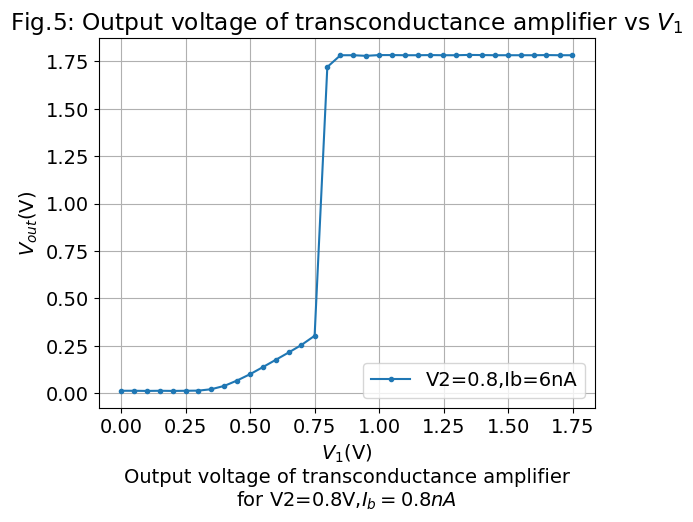

In [37]:
plt.plot(V1_sweep_ex3_getset,Vout_V1_sweep_ex3, ".-",label="V2=0.8,Ib=6nA")
plt.grid()
plt.title("Fig.5: Output voltage of transconductance amplifier vs $V_1$")
plt.xlabel('''$V_1$(V)
Output voltage of transconductance amplifier
for V2=0.8V,$I_b=0.8 nA$''')
plt.ylabel('''$V_{out}$(V)''')
plt.legend()

* Save raw data

In [34]:

# if the data looks nice, save it!
data_Vout_V1_sweep_ex3 = [V1_sweep_ex3_getset,Vout_V1_sweep_ex3,]
# save to csv file
np.savetxt('./data/data_Vout_V1_sweep_ex3.csv', data_Vout_V1_sweep_ex3, delimiter=',')

### 3.3.2 Different bias currents

* Repeat 3.3.1 with another two bias currents and compare the three curves

The bias current was switched from $I_b \approx 5.9\text{nA}$ to $I_b \approx 2.3\text{nA}$.

In [35]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 20)])

In [38]:
# your codes
import numpy as np
import time

V1_sweep_ex3_ib1 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex3_getset_ib1 = p.get_set_voltage(pyplane.DacChannel.AIN4)

Vout_V1_sweep_ex3_ib1 = []
V1_sweep_ex3_getset_ib1 = []

for n in range(len(V1_sweep_ex3_ib1)):
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3_ib1[n]) #
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex3_getset_ib1.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
#     Vout_V1_sweep_ex3.append(p.read_adc_instantaneous(13))
    Vout_V1_sweep_ex3_ib1.append(p.read_voltage(pyplane.AdcChannel.AOUT13))
    
data_Vout_V1_sweep_ex3_ib1 = [V1_sweep_ex3_getset_ib1,Vout_V1_sweep_ex3_ib1]
# save to csv file
np.savetxt('./data/data_Vout_V1_sweep_ex3_ib1.csv', data_Vout_V1_sweep_ex3_ib1, delimiter=',')

The bias current was switched from $I_b \approx 5.9\text{nA}$ to $I_b \approx 1.1\text{nA}$.

In [42]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 10)])

In [43]:
import numpy as np
import time

V1_sweep_ex3_ib2 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex3_getset_ib2 = p.get_set_voltage(pyplane.DacChannel.AIN4)

Vout_V1_sweep_ex3_ib2 = []
V1_sweep_ex3_getset_ib2 = []

for n in range(len(V1_sweep_ex3_ib2)):
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3_ib2[n]) #
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex3_getset_ib2.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
#     Vout_V1_sweep_ex3.append(p.read_adc_instantaneous(13))
    Vout_V1_sweep_ex3_ib2.append(p.read_voltage(pyplane.AdcChannel.AOUT13))
    
data_Vout_V1_sweep_ex3_ib2 = [V1_sweep_ex3_getset_ib2,Vout_V1_sweep_ex3_ib2]
# save to csv file
np.savetxt('./data/data_Vout_V1_sweep_ex3_ib2.csv', data_Vout_V1_sweep_ex3_ib2, delimiter=',')

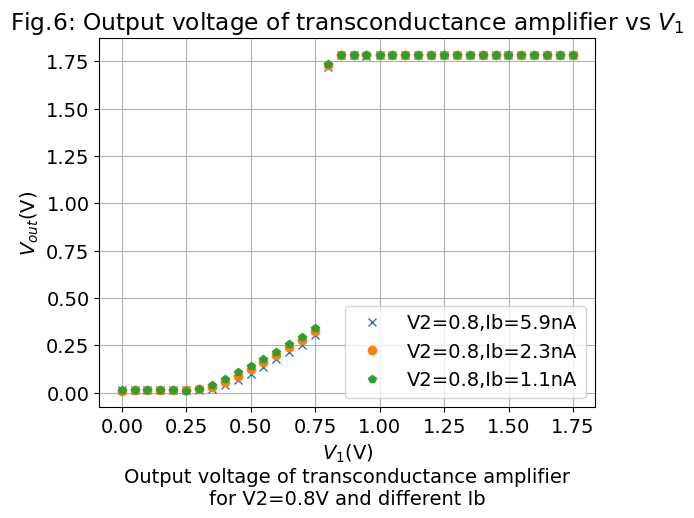

In [65]:
# plot the three curves on one figure to compare
sweep0, Ib0 = np.loadtxt('./data/data_Vout_V1_sweep_ex3.csv',delimiter=',')
sweep1, Ib1 = np.loadtxt('./data/data_Vout_V1_sweep_ex3_ib1.csv',delimiter=',')
sweep2, Ib2 = np.loadtxt('./data/data_Vout_V1_sweep_ex3_ib2.csv',delimiter=',')

plt.plot(sweep0,Ib0, "x",label="V2=0.8,Ib=5.9nA")
plt.plot(sweep0,Ib1, "o",label="V2=0.8,Ib=2.3nA")
plt.plot(sweep0,Ib2, "p",label="V2=0.8,Ib=1.1nA")
plt.grid()
plt.title("Fig.6: Output voltage of transconductance amplifier vs $V_1$")
plt.xlabel('''$V_1$(V)
Output voltage of transconductance amplifier
for V2=0.8V and different Ib''')
plt.ylabel('''$V_{out}$(V)''')
plt.legend()



**To conclude your observations:**

>The biais current $I_b$ does not seem to influence very much $V_out$ as a function as $V_1$. However, we observe a slight delay in the beggining of the rise of $V_{out}$ as $I_b$ increases.  



### 3.3.3 Different fixed voltages $V_n$

* Repeat 3.3.1 with another two fixed voltages $V_2$ and compare the three curves

Switch voltage from $V_2 = 0.8\text{V}$ to $V_2 = 0.4\text{V}$. The bias current was $I_b = 5.9\text{nA}$

In [51]:
# Set V2 = 0.4
p.set_voltage(pyplane.DacChannel.AIN4, 0.4) # V2 = ?
v2_real = p.get_set_voltage(pyplane.DacChannel.AIN4)
print("V2 is set to {} V".format(v2_real))

V2 is set to 0.399413526058197 V


In [52]:
# Set Ib = 5.9
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
   pyplane.Coach.BiasAddress.NTA_VB_N, \
   pyplane.Coach.BiasType.N, \
   pyplane.Coach.BiasGenMasterCurrent.I30nA, 51)])  #for  about 6  nA

In [53]:
# your codes
import numpy as np
import time

V1_sweep_ex3_v0 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex3_getset_v0 = p.get_set_voltage(pyplane.DacChannel.AIN4)

Vout_V1_sweep_ex3_v0 = []
V1_sweep_ex3_getset_v0 = []

for n in range(len(V1_sweep_ex3_v0)):
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3_v0[n]) #
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex3_getset_v0.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
#     Vout_V1_sweep_ex3.append(p.read_adc_instantaneous(13))
    Vout_V1_sweep_ex3_v0.append(p.read_voltage(pyplane.AdcChannel.AOUT13))
    
data_Vout_V1_sweep_ex3_v0 = [V1_sweep_ex3_getset_v0,Vout_V1_sweep_ex3_v0]
# save to csv file
np.savetxt('./data/data_Vout_V1_sweep_ex3_v0.csv', data_Vout_V1_sweep_ex3_v0, delimiter=',')

Switch voltage from $V_2 = 0.8\text{V}$ to $V_2 = 1.6\text{V}$. The bias current was $I_b = 5.9\text{nA}$

In [57]:
# Set V2 = 1.2
p.set_voltage(pyplane.DacChannel.AIN4, 1.6) # V2 = 1.6
v2_real = p.get_set_voltage(pyplane.DacChannel.AIN4)
print("V2 is set to {} V".format(v2_real))

V2 is set to 1.5994136333465576 V


In [58]:
import numpy as np
import time

V1_sweep_ex3_v1 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex3_getset_v1 = p.get_set_voltage(pyplane.DacChannel.AIN4)

Vout_V1_sweep_ex3_v1 = []
V1_sweep_ex3_getset_v1 = []

for n in range(len(V1_sweep_ex3_v1)):
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3_v1[n]) #
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex3_getset_v1.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
#     Vout_V1_sweep_ex3.append(p.read_adc_instantaneous(13))
    Vout_V1_sweep_ex3_v1.append(p.read_voltage(pyplane.AdcChannel.AOUT13))
    
data_Vout_V1_sweep_ex3_v1 = [V1_sweep_ex3_getset_v1,Vout_V1_sweep_ex3_v1]
# save to csv file
np.savetxt('./data/data_Vout_V1_sweep_ex3_v1.csv', data_Vout_V1_sweep_ex3_v1, delimiter=',')

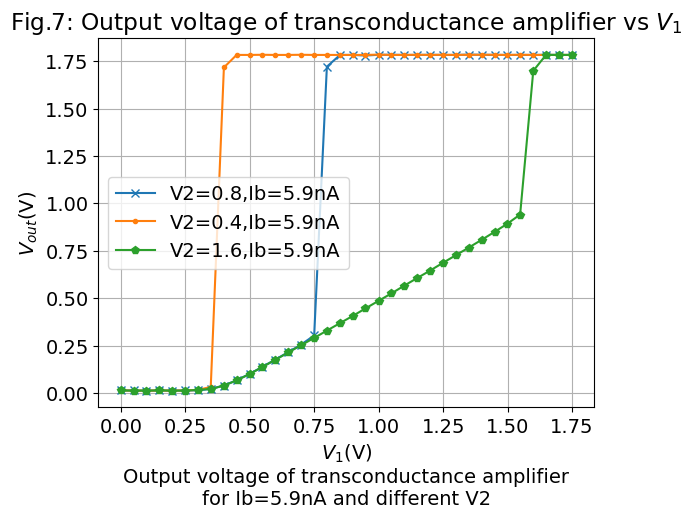

In [64]:
# plot the three curves on one figure to compare
# plot the three curves on one figure to compare
sweepv0, Ib0 = np.loadtxt('./data/data_Vout_V1_sweep_ex3.csv',delimiter=',')
sweepv1, v1 = np.loadtxt('./data/data_Vout_V1_sweep_ex3_v0.csv',delimiter=',')
sweepv2, v2 = np.loadtxt('./data/data_Vout_V1_sweep_ex3_v1.csv',delimiter=',')

plt.plot(sweep0,Ib0, "x-",label="V2=0.8,Ib=5.9nA")
plt.plot(sweep0,v1, ".-",label="V2=0.4,Ib=5.9nA")
plt.plot(sweep0,v2, "p-",label="V2=1.6,Ib=5.9nA")
plt.grid()
plt.title("Fig.7: Output voltage of transconductance amplifier vs $V_1$")
plt.xlabel('''$V_1$(V)
Output voltage of transconductance amplifier
for Ib=5.9nA and different V2''')
plt.ylabel('''$V_{out}$(V)''')
plt.legend()

**To conclude your observations:**

>Varying V2 highly influences when $V_{out}$ will make the switch (of course), we can also see that the bigger $V_2$, the longer $V_{out}$ increases linearly with $V_1$ (with a slope of kappa).



## 3.4 Output current vs. input voltage

### 3.4.1 Basic measurement

* Set bias current $I_b$

In [22]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 51)])

Switch bias current back to $I_b = 5.9\text{nA}$.

* Assign common mode voltage $V_{cm}$

In [10]:
Vcm_ex3 = 0.9 # Vcm = 0.9V

* Sweep differential voltage $V_{diff}$ and measure $I_{out}$ (Hint: use get_set_voltage to get the real value set on the DAC)

In [24]:
import numpy as np
import time

V1_sweep_ex3 = np.arange(0.6, 1.2, 0.01) # voltage V1 sweep range

#V2_ex3_getset = p.get_set_voltage(pyplane.DacChannel.AIN4)

V2_ex3 = []
V1_sweep_ex3_getset = []
V2_ex3_getset = []
c2f_Iout_UO_Vcm_ex3 = []
c2f_Iout_UBO_Vcm_ex3 = []

for n in range(len(V1_sweep_ex3)):
    
    # calculate V2 via Vcm and V1
    V2_ex3.append(2*Vcm_ex3-V1_sweep_ex3[n])
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3[n]) #
    p.set_voltage(pyplane.DacChannel.AIN4,V2_ex3[n]) #

    time.sleep(0.2) # settle time
    
    V1_sweep_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
    V2_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN4))
    
    # read c2f values 
    c2f_Iout_ex3_temp = p.read_c2f_output(0.1)
    c2f_Iout_UO_Vcm_ex3.append(c2f_Iout_ex3_temp[11])
    c2f_Iout_UBO_Vcm_ex3.append(c2f_Iout_ex3_temp[12])
    
# print(V1_sweep_ex3_getset)
# print(V2_ex3_getset)
# print(c2f_Iout_UO_Vcm_ex3)
# print(c2f_Iout_UBO_Vcm_ex3)


* Save raw data

In [25]:
# if the data looks nice, save it!
data_Iout_Vcm09_ex3 = [V1_sweep_ex3_getset,V2_ex3_getset,c2f_Iout_UO_Vcm_ex3,c2f_Iout_UBO_Vcm_ex3]
# save to csv file
np.savetxt('./data/V1_sweep_Iout_Vcm09_ex3.csv', data_Iout_Vcm09_ex3, delimiter=',')

* Plot raw data (C2F frequncy vs. 𝑉𝑑𝑖𝑓𝑓)

[-0.60000008 -0.58064526 -0.55953091 -0.53841656 -0.52082115 -0.49970675
 -0.4785924  -0.4609971  -0.43988276 -0.41876841 -0.40117306 -0.38005871
 -0.35894436 -0.34134907 -0.32023472 -0.29912025 -0.2815249  -0.26041055
 -0.2392962  -0.22170091 -0.20058656 -0.17947215 -0.1583578  -0.14076245
 -0.1196481  -0.09853375 -0.08093846 -0.05982405 -0.0387097  -0.02111435
  0.          0.02111435  0.0387097   0.05982405  0.08093846  0.09853375
  0.1196481   0.14076245  0.1583578   0.17947215  0.20058656  0.22170091
  0.2392962   0.26041055  0.2815249   0.29912025  0.32023472  0.34134907
  0.35894436  0.38005871  0.40117306  0.41876841  0.43988276  0.4609971
  0.4785924   0.49970675  0.52082115  0.53841656  0.55953091  0.58064526]
[-3775. -3757. -3754. -3753. -3743. -3742. -3725. -3716. -3696. -3684.
 -3681. -3654. -3631. -3602. -3577. -3533. -3506. -3433. -3362. -3280.
 -3188. -3048. -2856. -2660. -2344. -1881. -1363.  -516.   633.  1819.
  3311.  3896.  4324.  4740.  5026.  5162.  5228.  5228. 

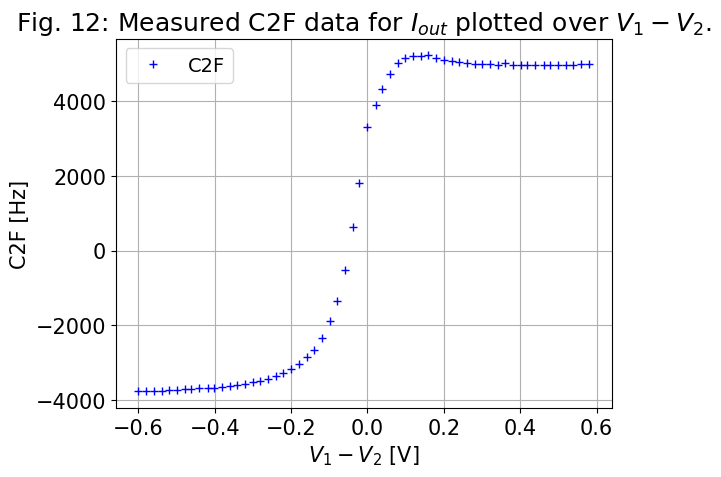

In [26]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

V1_sweep_Iout_Vcm09_ex3_getset,V2_Iout_Vcm09_ex3_getset,c2f_Iout_UO_Vcm09_ex3,c2f_Iout_UBO_Vcm09_ex3 = np.loadtxt('./data/V1_sweep_Iout_Vcm09_ex3.csv', delimiter=',')

Vdiff_Vcm09 = V1_sweep_Iout_Vcm09_ex3_getset-V2_Iout_Vcm09_ex3_getset
print(Vdiff_Vcm09)
c2f_Iout_Vcm09 = c2f_Iout_UO_Vcm09_ex3 - c2f_Iout_UBO_Vcm09_ex3
print(c2f_Iout_Vcm09)

plt.plot(Vdiff_Vcm09,c2f_Iout_Vcm09,'b+')

plt.xlabel('$V_1-V_2$ [V]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F'],prop={'size': 14})
plt.title('Fig. 12: Measured C2F data for $I_{out}$ plotted over $V_1-V_2$.')
plt.grid()
plt.show()

* Convert c2f frenquncy to current and plot. You may need the factors a2, a1, a0 that you get when fitting the I(f) function in section 3 to convert frequency to current.

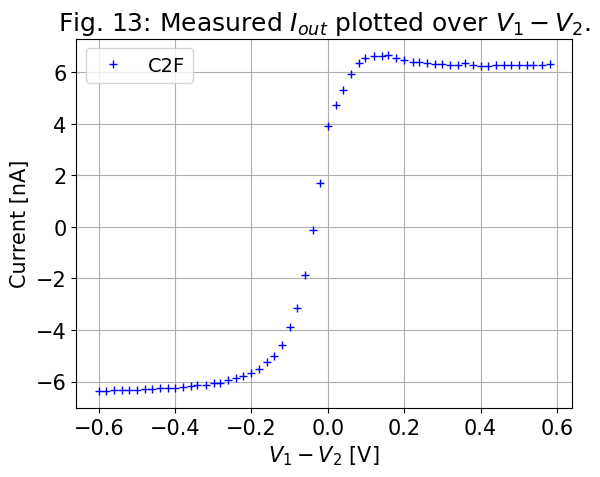

In [29]:
a2_1 = 4.409e-08
a1_1 = 0.001044
a0_1 = -0.06894

a2_2 = 2.977e-08
a1_2 = 0.001575
a0_2 = -0.06453

I_plus = a2_1*c2f_Iout_UO_Vcm09_ex3**2+a1_1*c2f_Iout_UO_Vcm09_ex3+a0_1
I_minus = a2_2*c2f_Iout_UBO_Vcm09_ex3**2+a1_2*c2f_Iout_UBO_Vcm09_ex3+a0_2

plt.plot(Vdiff_Vcm09,I_plus-I_minus,'b+')

plt.xlabel('$V_1-V_2$ [V]')
plt.ylabel('Current [nA]')
plt.legend(['C2F'],prop={'size': 14})
plt.title('Fig. 13: Measured $I_{out}$ plotted over $V_1-V_2$.')
plt.grid()
plt.show()

* Compute transconductance

In [ ]:
#gm = Ib*kappa / 2 UT



* Explain any asymmetries in the amplifier’s I-V curve and the offset voltage in terms of mismatch between devices in the mirror and differential pair.
Do you think we can distinguish the effects of mismatch in the current mirror and in the differential pair?
The main point here is to recognize that there will be non-idealities, to understand where they arise.

### 3.4.2 Different bias currents

* Repeat 3.4.1 with another two bias currents and compare the three curves

In [11]:
# Set Ib = ?
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 90)])

The bias current was switched from $I_b \approx 5.9\text{nA}$ to $I_b \approx 10.5\text{nA}$.

In [12]:
import numpy as np
import time

V1_sweep_ex3 = np.arange(0.6, 1.2, 0.01) # voltage V1 sweep range

#V2_ex3_getset = p.get_set_voltage(pyplane.DacChannel.AIN4)

V2_ex3 = []
V1_sweep_ex3_getset = []
V2_ex3_getset = []
c2f_Iout_UO_Vcm_ex3 = []
c2f_Iout_UBO_Vcm_ex3 = []

for n in range(len(V1_sweep_ex3)):
    
    # calculate V2 via Vcm and V1
    V2_ex3.append(2*Vcm_ex3-V1_sweep_ex3[n])
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3[n]) #
    p.set_voltage(pyplane.DacChannel.AIN4,V2_ex3[n]) #

    time.sleep(0.2) # settle time
    
    V1_sweep_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
    V2_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN4))
    
    # read c2f values 
    c2f_Iout_ex3_temp = p.read_c2f_output(0.1)
    c2f_Iout_UO_Vcm_ex3.append(c2f_Iout_ex3_temp[11])
    c2f_Iout_UBO_Vcm_ex3.append(c2f_Iout_ex3_temp[12])
    
# print(V1_sweep_ex3_getset)
# print(V2_ex3_getset)
# print(c2f_Iout_UO_Vcm_ex3)
# print(c2f_Iout_UBO_Vcm_ex3)

# if the data looks nice, save it!
data_Iout_Vcm09_ex3_I1 = [V1_sweep_ex3_getset,V2_ex3_getset,c2f_Iout_UO_Vcm_ex3,c2f_Iout_UBO_Vcm_ex3]
# save to csv file
np.savetxt('./data/V1_sweep_Iout_Vcm09_ex3_I1.csv', data_Iout_Vcm09_ex3_I1, delimiter=',')


Plot raw data

[-0.60000008 -0.58064526 -0.55953091 -0.53841656 -0.52082115 -0.49970675
 -0.4785924  -0.4609971  -0.43988276 -0.41876841 -0.40117306 -0.38005871
 -0.35894436 -0.34134907 -0.32023472 -0.29912025 -0.2815249  -0.26041055
 -0.2392962  -0.22170091 -0.20058656 -0.17947215 -0.1583578  -0.14076245
 -0.1196481  -0.09853375 -0.08093846 -0.05982405 -0.0387097  -0.02111435
  0.          0.02111435  0.0387097   0.05982405  0.08093846  0.09853375
  0.1196481   0.14076245  0.1583578   0.17947215  0.20058656  0.22170091
  0.2392962   0.26041055  0.2815249   0.29912025  0.32023472  0.34134907
  0.35894436  0.38005871  0.40117306  0.41876841  0.43988276  0.4609971
  0.4785924   0.49970675  0.52082115  0.53841656  0.55953091  0.58064526]
[-6415. -6407. -6391. -6380. -6374. -6367. -6357. -6347. -6336. -6324.
 -6313. -6296. -6282. -6258. -6228. -6191. -6162. -6123. -6064. -6001.
 -5907. -5779. -5602. -5396. -5023. -4470. -3789. -2627.  -928.   873.
  3267.  4275.  5158.  6201.  6915.  7367.  7721.  7991. 

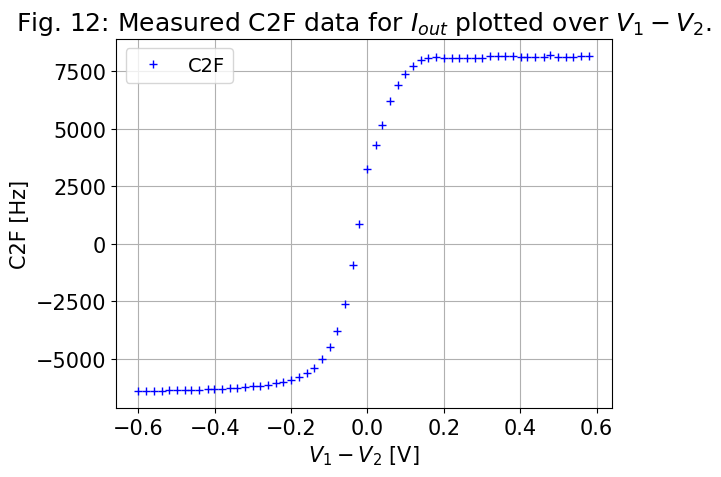

In [13]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

V1_sweep_Iout_Vcm09_ex3_getset_I1,V2_Iout_Vcm09_ex3_getset_I1,c2f_Iout_UO_Vcm09_ex3_I1,c2f_Iout_UBO_Vcm09_ex3_I1 = np.loadtxt('./data/V1_sweep_Iout_Vcm09_ex3_I1.csv', delimiter=',')

Vdiff_Vcm09_I1 = V1_sweep_Iout_Vcm09_ex3_getset_I1-V2_Iout_Vcm09_ex3_getset_I1
print(Vdiff_Vcm09_I1)
c2f_Iout_Vcm09_I1 = c2f_Iout_UO_Vcm09_ex3_I1 - c2f_Iout_UBO_Vcm09_ex3_I1
print(c2f_Iout_Vcm09_I1)

plt.plot(Vdiff_Vcm09_I1,c2f_Iout_Vcm09_I1,'b+')

plt.xlabel('$V_1-V_2$ [V]')
plt.ylabel('C2F [Hz]')
plt.legend(['C2F'],prop={'size': 14})
plt.title('Fig. 12: Measured C2F data for $I_{out}$ plotted over $V_1-V_2$.')
plt.grid()
plt.show()

Convert frequency 

In [14]:
# Set Ib = 2.3 nA
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 20)])

In [15]:
import numpy as np
import time

V1_sweep_ex3 = np.arange(0.6, 1.2, 0.01) # voltage V1 sweep range

#V2_ex3_getset = p.get_set_voltage(pyplane.DacChannel.AIN4)

V2_ex3 = []
V1_sweep_ex3_getset = []
V2_ex3_getset = []
c2f_Iout_UO_Vcm_ex3 = []
c2f_Iout_UBO_Vcm_ex3 = []

for n in range(len(V1_sweep_ex3)):
    
    # calculate V2 via Vcm and V1
    V2_ex3.append(2*Vcm_ex3-V1_sweep_ex3[n])
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3[n]) #
    p.set_voltage(pyplane.DacChannel.AIN4,V2_ex3[n]) #

    time.sleep(0.2) # settle time
    
    V1_sweep_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
    V2_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN4))
    
    # read c2f values 
    c2f_Iout_ex3_temp = p.read_c2f_output(0.1)
    c2f_Iout_UO_Vcm_ex3.append(c2f_Iout_ex3_temp[11])
    c2f_Iout_UBO_Vcm_ex3.append(c2f_Iout_ex3_temp[12])
    
# print(V1_sweep_ex3_getset)
# print(V2_ex3_getset)
# print(c2f_Iout_UO_Vcm_ex3)
# print(c2f_Iout_UBO_Vcm_ex3)

# if the data looks nice, save it!
data_Iout_Vcm09_ex3_I2 = [V1_sweep_ex3_getset,V2_ex3_getset,c2f_Iout_UO_Vcm_ex3,c2f_Iout_UBO_Vcm_ex3]
# save to csv file
np.savetxt('./data/V1_sweep_Iout_Vcm09_ex3_I2.csv', data_Iout_Vcm09_ex3_I2, delimiter=',')

The bias current was switched from $I_b \approx 5.9\text{nA}$ to $I_b \approx 2.3\text{nA}$.


**To conclude your observations:**

xxx



### 3.4.3 Different common mode voltages

* Repeat 3.4.1 with another two common mode voltages and compare the three curves

In [21]:
# Assign common mode voltage 𝑉𝑐𝑚
Vcm_ex3 = 0.4

In [17]:
# Set Ib = ?
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.NTA_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 90)])

The bias current was switched back to $I_b \approx ???\text{nA}$.

In [26]:
# your code, data aquisition
import numpy as np
import time

V1_sweep_ex3 = np.arange(0.1, 0.3, 0.01) # voltage V1 sweep range

#V2_ex3_getset = p.get_set_voltage(pyplane.DacChannel.AIN4)

V2_ex3 = []
V1_sweep_ex3_getset = []
V2_ex3_getset = []
c2f_Iout_UO_Vcm_ex3 = []
c2f_Iout_UBO_Vcm_ex3 = []

for n in range(len(V1_sweep_ex3)):
    
    # calculate V2 via Vcm and V1
    V2_ex3.append(2*Vcm_ex3-V1_sweep_ex3[n])
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3[n]) #
    p.set_voltage(pyplane.DacChannel.AIN4,V2_ex3[n]) #

    time.sleep(0.2) # settle time
    
    V1_sweep_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
    V2_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN4))
    
    # read c2f values 
    c2f_Iout_ex3_temp = p.read_c2f_output(0.1)
    c2f_Iout_UO_Vcm_ex3.append(c2f_Iout_ex3_temp[11])
    c2f_Iout_UBO_Vcm_ex3.append(c2f_Iout_ex3_temp[12])
    
# print(V1_sweep_ex3_getset)
# print(V2_ex3_getset)
# print(c2f_Iout_UO_Vcm_ex3)
# print(c2f_Iout_UBO_Vcm_ex3)

# if the data looks nice, save it!
data_Iout_Vcm09_ex3_Vcm1 = [V1_sweep_ex3_getset,V2_ex3_getset,c2f_Iout_UO_Vcm_ex3,c2f_Iout_UBO_Vcm_ex3]
# save to csv file
np.savetxt('./data/V1_sweep_Iout_Vcm09_ex3_Vcm1.csv', data_Iout_Vcm09_ex3_Vcm1, delimiter=',')


In [27]:
# Assign common mode voltage 𝑉𝑐𝑚
Vcm_ex3 = 0.2

In [28]:
# your code, data aquisition
import numpy as np
import time

V1_sweep_ex3 = np.arange(0.1, 0.3, 0.01) # voltage V1 sweep range

#V2_ex3_getset = p.get_set_voltage(pyplane.DacChannel.AIN4)

V2_ex3 = []
V1_sweep_ex3_getset = []
V2_ex3_getset = []
c2f_Iout_UO_Vcm_ex3 = []
c2f_Iout_UBO_Vcm_ex3 = []

for n in range(len(V1_sweep_ex3)):
    
    # calculate V2 via Vcm and V1
    V2_ex3.append(2*Vcm_ex3-V1_sweep_ex3[n])
    
    p.set_voltage(pyplane.DacChannel.AIN3,V1_sweep_ex3[n]) #
    p.set_voltage(pyplane.DacChannel.AIN4,V2_ex3[n]) #

    time.sleep(0.2) # settle time
    
    V1_sweep_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN3))
    V2_ex3_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN4))
    
    # read c2f values 
    c2f_Iout_ex3_temp = p.read_c2f_output(0.1)
    c2f_Iout_UO_Vcm_ex3.append(c2f_Iout_ex3_temp[11])
    c2f_Iout_UBO_Vcm_ex3.append(c2f_Iout_ex3_temp[12])
    
# print(V1_sweep_ex3_getset)
# print(V2_ex3_getset)
# print(c2f_Iout_UO_Vcm_ex3)
# print(c2f_Iout_UBO_Vcm_ex3)

# if the data looks nice, save it!
data_Iout_Vcm09_ex3_Vcm2 = [V1_sweep_ex3_getset,V2_ex3_getset,c2f_Iout_UO_Vcm_ex3,c2f_Iout_UBO_Vcm_ex3]
# save to csv file
np.savetxt('./data/V1_sweep_Iout_Vcm09_ex3_Vcm2.csv', data_Iout_Vcm09_ex3_Vcm2, delimiter=',')


**To conclude your observations:**

xxxxxxxx



**What do you observe when the common mode voltage $V_{cm}$ is too small (e.g. 0.2V or 0.3V)?**
**Does it have a sigmoid shape? If not, try to explain why.**

xxxxxx


# 4 P-Type 5T Transamp (**OPTIONAL**)

## 4.0 Schematic and pin map

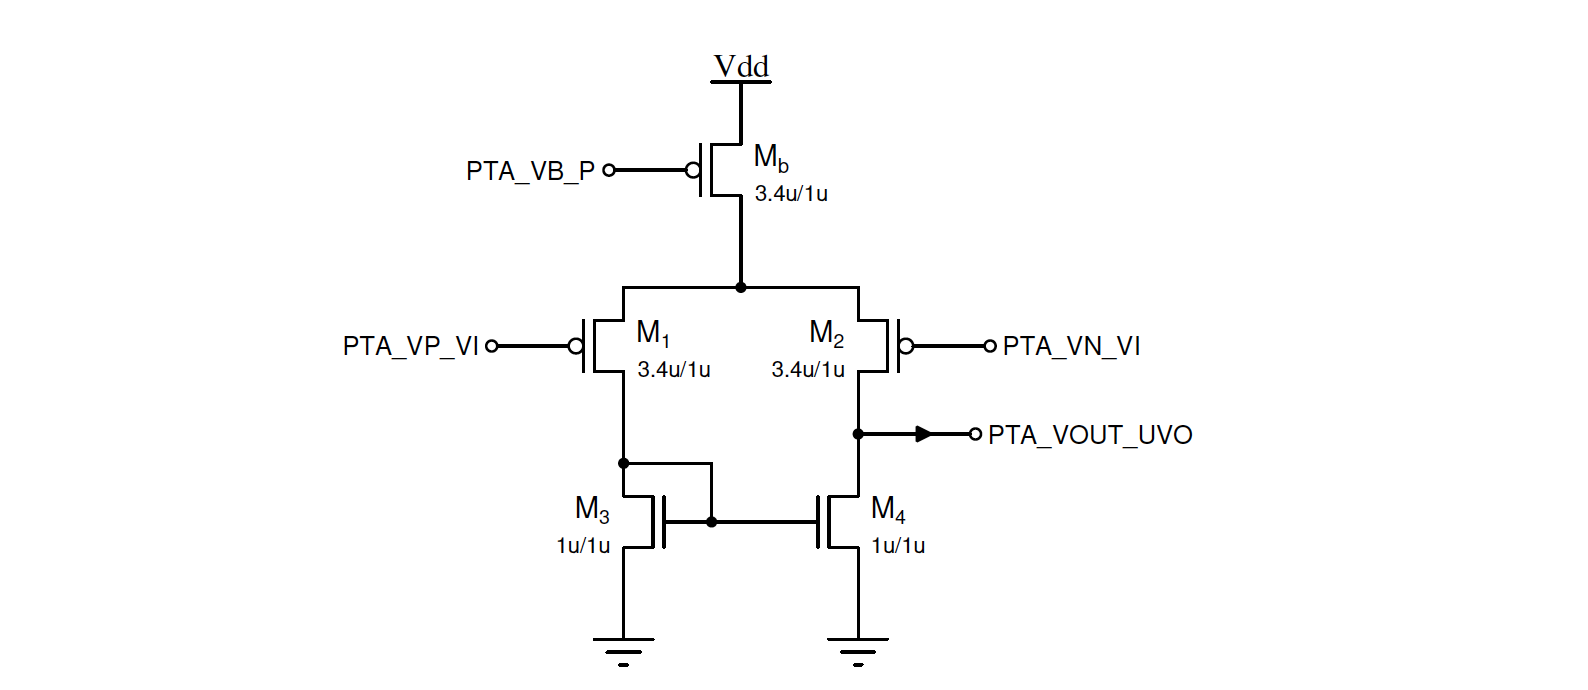

**$V_1$ = $V_p$ = PTA_VP_VI = AIN7**

**$V_2$ = $V_n$ = PTA_VN_VI = AIN8**

**$V_{out}$ = PTA_VOUT_UVO = ADC[12]**

**$I_{out}$ = $I_+ - I_-$ = PTA_IOUT_UO - PTA_IOUT_UBO = C2F[13] - C2F[14]**

**Note: There are three identical PTA circuits with the same bias and input voltages, one with the output open-circuited and routed out at PTA_VOUT_UVO, the other two with $V_{out}$ fixed to 1V but $I_{out}$ routed out through N- and P- type current mirror at PTA_IOUT_UO and PTA_IOUT_UBO.**

## 4.1 Chip configuration

In [9]:
# configure P type TransAmp
p.send_coach_events([pyplane.Coach.generate_aerc_event( \
    pyplane.Coach.CurrentOutputSelect.SelectLine5, \
    pyplane.Coach.VoltageOutputSelect.SelectLine1, \
    pyplane.Coach.VoltageInputSelect.SelectLine1, \
    pyplane.Coach.SynapseSelect.NoneSelected, 0)])

## 4.2 Calibration of C2F channels

Here you need to calibrate PTA_IOUT_UO and PTA_IOUT_UBO in the same way as the last lab. **Notice the W/L ratio of 3.4 of Mb**.

### 4.2.1 PTA_IOUT_UO

* Set fixed voltages for $V_1$ and $V_2$

In [ ]:
p.set_voltage(pyplane.DacChannel.AIN7, ???) # V1 = ???
p.set_voltage(pyplane.DacChannel.AIN8, ???) # V2 = ???

Set $V_1\gg V_2$.

* Data aquisition (Hint: use master current 30 nA)

In [ ]:
...
...

# Notice the W/L ratio of 3.4 of Mb when setting Ib.
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PTA_VB_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, ???)])
...


* Plot

* Save data

In [20]:
# if the data looks nice, save it!


* Extract the function $I_+\left(f_+\right)$ (Hint: use higher order polynomial to increase accuracy)

### 4.2.2 PTA_IOUT_UBO

* Set fixed voltages for $V_1$ and $V_2$

In [322]:
p.set_voltage(pyplane.DacChannel.AIN7, ???) # V1 = ??
p.set_voltage(pyplane.DacChannel.AIN8, ???) # V2 = ??

Set $V_1\ll V_2$.

* Data aquisition (Hint: use master current 30 nA)

In [ ]:
# Notice the W/L ratio of 3.4 of Mb when setting Ib.


* Plot

* Save data

In [325]:
# if the data looks nice, save it!


* Extract the function $I_-\left(f_-\right)$ (Hint: use higher order polynomial to increase accuracy)

## 4.3 Output voltage vs. input voltage

### 4.3.1 Basic measurement

* Set bias current $I_b$

In [431]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PTA_VB_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, ???)])


The bias current is set to (Notice the W/L ratio of 3.4 of Mb.)

$I_b = w\dfrac{BG_{\text{fine}}}{256}I_{BG_{\text{master}}} = 3.4 \dfrac{???}{256}\cdot 30\text{nA} = ??? \text{nA}$.

* Set fixed value of $V_2$ (Hint: use get_set_voltage to get the real value set on the DAC)

In [280]:
p.set_voltage(pyplane.DacChannel.AIN8, ???) # V2 = ???

Set $V_2= ???\text{V}$.

* Sweep $V_1$ and measure $V_{out}$ (Hint: use get_set_voltage to get the real value set on the DAC)

* Plot raw data

* Save raw data

In [11]:
# if the data looks nice, save it!


### 4.3.2 Different bias currents (**optional**)

* Repeat 4.3.1 with another two bias currents and compare the three curves

Switch bias current from $I_b = ???\text{nA}$ in the basic measurement to $I_b = ???\text{nA}$.

**To conclude your observations:**

xxxxxxxx



### 4.3.3 Different fixed voltages $V_n$ (**optional**)

* Repeat 4.3.1 with another two fixed voltages $V_2$ and compare the three curves

In [ ]:
 p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PTA_VB_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, ???)])

Switch bias current back to $I_b = ??? \text{nA}$.

In [ ]:
p.set_voltage(pyplane.DacChannel.AIN8, ???) # V2 = ???

* Repeat 4.3.1 with another two fixed voltages $V_2$ and compare the three curves

In [432]:
p.set_voltage(pyplane.DacChannel.AIN8, ???) # V2 = ??

Switch input voltage from $V_2= ??? \text{V}$ in the basic measurement to $V_2=\text{V}$.

Switch bias current back to $I_b = 7.5\text{nA}$.

In [ ]:
import numpy as np
import time

V1_sweep_ex4 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex4_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_ex4 = []
V1_sweep_ex4_getset = []

for n in range(len(V1_sweep_ex4)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex4[n]) #
    
    time.sleep(0.5) # settle time
    
    V1_sweep_ex4_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_ex4.append(p.read_adc_instantaneous(12))
    
print(V2_ex4_getset)
print(V1_sweep_ex4_getset)
print(Vout_V1_sweep_ex4)

**To conclude your observations:**

xxxxxxxx



## 4.4 Output current vs. input voltage

### 4.4.1 Basic measurement

* Set bias current $I_b$

In [329]:
 p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PTA_VB_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, ???)])

Bias current is switched back to $I_b = ???? \text{nA}$.

* Assign common mode voltage $V_{cm}$

In [330]:
Vcm_ex4 = ??

Common mode voltage is set to $V_{cm}= ??? \text{V}$.

* Sweep differential voltage $V_{diff}$ and measure $I_{out}$ (Hint: use get_set_voltage to get the real value set on the DAC)

* Plot raw data (C2F )

* Save raw data

In [332]:
# if the data looks nice, save it!


* Convert rate to current and plot

* Compute transconductance

* Explain any asymmetries in the amplifier’s I-V curve and the offset voltage in terms of mismatch between devices in the mirror and differential pair, and the Early effect.


### 4.4.2 Different bias currents (**optional**)

* Repeat 4.4.1 with another two bias currents and compare the three curves

Switch bias current from $I_b= ??? \text{nA}$ in the basic measurement to $I_b = ???\text{nA}$.

**To conclude your observations:**

xxxxxxxx



### 4.4.3 Different common mode voltages (**optional**)

* Repeat 4.4.1 with another two common mode voltages and compare the three curves

The common mode voltage was changed from $V_{cm} = ??? \text{V}$ to $V_{cm} = ??? \text{V}$.

Switch bias current back to $I_b= ??? \text{nA}$.

**To conclude your observations:**

xxxxxxxx



# 5 Wide-range Transamp

## 5.0 Schematic and pin map

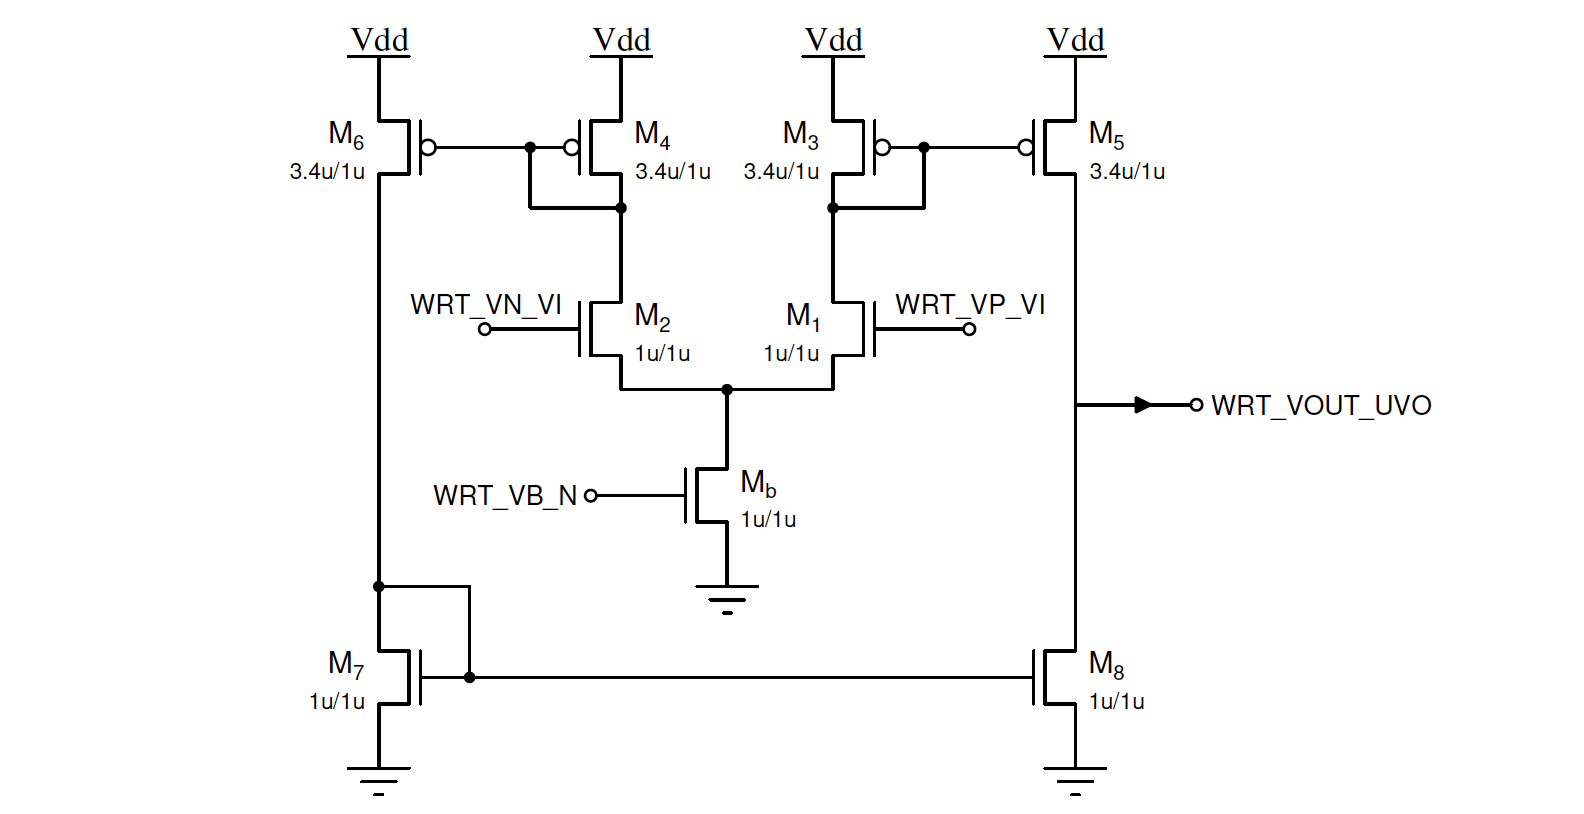

**$V_1$ = $V_p$ = WRT_VP_VI = AIN7**

**$V_2$ = $V_n$ = WRT_VN_VI = AIN8**

**$V_{out}$ = WRT_VOUT_UVO = ADC[11]**

## 5.1 Chip configuration

In [8]:
# configure wide-range TransAmp
p.send_coach_events([pyplane.Coach.generate_aerc_event( \
    pyplane.Coach.CurrentOutputSelect.SelectLine5, \
    pyplane.Coach.VoltageOutputSelect.SelectLine1, \
    pyplane.Coach.VoltageInputSelect.SelectLine2, \
    pyplane.Coach.SynapseSelect.NoneSelected, 0)])

## 5.2 Output voltage vs. input voltage

### 5.2.1 Basic measurement

* Set bias current $I_b$

In [30]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.WRT_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 85)])

The bias current is set to

$I_b = w\dfrac{BG_{\text{fine}}}{256}I_{BG_{\text{master}}} = \dfrac{85}{256}\cdot 30\text{nA} \approx 9.961\text{nA}$.

* Set fixed value of $V_2$ (Hint: use get_set_voltage to get the real value set on the DAC)

In [9]:
p.set_voltage(pyplane.DacChannel.AIN8,0.9) # V2 = 0.9

0.8991203308105469

The input voltage is set to $V_2 = 0.9\text{V}$.

* Sweep $V_1$ and measure $V_{out}$ (Hint: use get_set_voltage to get the real value set on the DAC)

In [34]:
import numpy as np
import time

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_ex5 = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #
    
    time.sleep(0.2) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_ex5.append(p.read_voltage(pyplane.AdcChannel.AOUT11))
    
print(V2_ex5_getset)
print(V1_sweep_ex5_getset)
print(Vout_V1_sweep_ex5)

data = [V1_sweep_ex5_getset,Vout_V1_sweep_ex5]
np.savetxt('./data/V1_sweep_Vout_V209_ex5.csv', data, delimiter=',')


0.8991203308105469
[0.0, 0.04926686733961105, 0.0985337346792221, 0.1495601385831833, 0.19882699847221375, 0.24985340237617493, 0.2991202771663666, 0.3483871519565582, 0.399413526058197, 0.44868040084838867, 0.49970680475234985, 0.5489736795425415, 0.5982405543327332, 0.6492669582366943, 0.698533833026886, 0.7495601773262024, 0.798827052116394, 0.8498534560203552, 0.8991203308105469, 0.9483872056007385, 0.9994136095046997, 1.0486804246902466, 1.0997068881988525, 1.1489737033843994, 1.1982406377792358, 1.2492669820785522, 1.2985339164733887, 1.349560260772705, 1.3988271951675415, 1.449853539466858, 1.4991203546524048, 1.5483872890472412, 1.5994136333465576, 1.648680567741394, 1.6997069120407104, 1.7489738464355469]
[0.011279297061264515, 0.0120849609375, 0.012890624813735485, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.011279297061264515, 0.0120849609375, 0.011279297061264515, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.0120849609375, 

* Plot raw data

* Save raw data

In [33]:
# if the data looks nice, save it!


### 5.2.2 Different bias currents

* Repeat 5.2.1 with another two bias currents and compare the three curves

The bias current is switched to $I_b \approx ??? \text{nA}$ from $I_b \approx ??? \text{nA}$ in the basic measurement.

In [10]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.WRT_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 40)])

In [11]:
import numpy as np
import time

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_ex5 = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #
    
    time.sleep(0.2) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_ex5.append(p.read_voltage(pyplane.AdcChannel.AOUT11))
    
print(V2_ex5_getset)
print(V1_sweep_ex5_getset)
print(Vout_V1_sweep_ex5)

data = [V1_sweep_ex5_getset,Vout_V1_sweep_ex5]
np.savetxt('./data/V1_sweep_Vout_V209_ex5_I1.csv', data, delimiter=',')

0.8991203308105469
[0.0, 0.04926686733961105, 0.0985337346792221, 0.1495601385831833, 0.19882699847221375, 0.24985340237617493, 0.2991202771663666, 0.3483871519565582, 0.399413526058197, 0.44868040084838867, 0.49970680475234985, 0.5489736795425415, 0.5982405543327332, 0.6492669582366943, 0.698533833026886, 0.7495601773262024, 0.798827052116394, 0.8498534560203552, 0.8991203308105469, 0.9483872056007385, 0.9994136095046997, 1.0486804246902466, 1.0997068881988525, 1.1489737033843994, 1.1982406377792358, 1.2492669820785522, 1.2985339164733887, 1.349560260772705, 1.3988271951675415, 1.449853539466858, 1.4991203546524048, 1.5483872890472412, 1.5994136333465576, 1.648680567741394, 1.6997069120407104, 1.7489738464355469]
[0.011279297061264515, 0.011279297061264515, 0.011279297061264515, 0.011279297061264515, 0.0120849609375, 0.0120849609375, 0.011279297061264515, 0.0120849609375, 0.0120849609375, 0.011279297061264515, 0.012890624813735485, 0.0120849609375, 0.0120849609375, 0.01127929706126451

In [12]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.WRT_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 20)])

In [13]:
import numpy as np
import time

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_ex5 = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #
    
    time.sleep(0.2) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_ex5.append(p.read_voltage(pyplane.AdcChannel.AOUT11))
    
print(V2_ex5_getset)
print(V1_sweep_ex5_getset)
print(Vout_V1_sweep_ex5)

data = [V1_sweep_ex5_getset,Vout_V1_sweep_ex5]
np.savetxt('./data/V1_sweep_Vout_V209_ex5_I2.csv', data, delimiter=',')

0.8991203308105469
[0.0, 0.04926686733961105, 0.0985337346792221, 0.1495601385831833, 0.19882699847221375, 0.24985340237617493, 0.2991202771663666, 0.3483871519565582, 0.399413526058197, 0.44868040084838867, 0.49970680475234985, 0.5489736795425415, 0.5982405543327332, 0.6492669582366943, 0.698533833026886, 0.7495601773262024, 0.798827052116394, 0.8498534560203552, 0.8991203308105469, 0.9483872056007385, 0.9994136095046997, 1.0486804246902466, 1.0997068881988525, 1.1489737033843994, 1.1982406377792358, 1.2492669820785522, 1.2985339164733887, 1.349560260772705, 1.3988271951675415, 1.449853539466858, 1.4991203546524048, 1.5483872890472412, 1.5994136333465576, 1.648680567741394, 1.6997069120407104, 1.7489738464355469]
[0.011279297061264515, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.012890624813735485, 0.0120849609375, 0.011279297061264515, 0.0120849609375, 0.011279297061264515, 0.011279297061264515, 0.011279297061264515, 0.011279297061264515, 0.

**To conclude your observations:**

xxxxxxxx



### 5.2.3 Different fixed voltages $V_n$

* Repeat 5.2.1 with another two fixed voltages $V_2$ and compare the three curves

The bias current is switched back to $I_b \approx ??? \text{nA}$.

In [14]:
# set Ib = ???
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.WRT_VB_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 85)])

In [15]:
p.set_voltage(pyplane.DacChannel.AIN8, 0.4)    # V2 = ???

0.399413526058197

In [16]:
import numpy as np
import time

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_ex5 = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #
    
    time.sleep(0.2) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_ex5.append(p.read_voltage(pyplane.AdcChannel.AOUT11))
    
print(V2_ex5_getset)
print(V1_sweep_ex5_getset)
print(Vout_V1_sweep_ex5)

data = [V1_sweep_ex5_getset,Vout_V1_sweep_ex5]
np.savetxt('./data/V1_sweep_Vout_V209_ex5_V204.csv', data, delimiter=',')

0.399413526058197
[0.0, 0.04926686733961105, 0.0985337346792221, 0.1495601385831833, 0.19882699847221375, 0.24985340237617493, 0.2991202771663666, 0.3483871519565582, 0.399413526058197, 0.44868040084838867, 0.49970680475234985, 0.5489736795425415, 0.5982405543327332, 0.6492669582366943, 0.698533833026886, 0.7495601773262024, 0.798827052116394, 0.8498534560203552, 0.8991203308105469, 0.9483872056007385, 0.9994136095046997, 1.0486804246902466, 1.0997068881988525, 1.1489737033843994, 1.1982406377792358, 1.2492669820785522, 1.2985339164733887, 1.349560260772705, 1.3988271951675415, 1.449853539466858, 1.4991203546524048, 1.5483872890472412, 1.5994136333465576, 1.648680567741394, 1.6997069120407104, 1.7489738464355469]
[0.0120849609375, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.0120849609375, 0.012890624813735485, 0.011279297061264515, 0.01933593675494194, 1.7756836414337158, 1.7926025390625, 1.778100609779358, 1.782128930091858, 1.78857421875, 1.795019507408142, 1.7845458984375, 

In [17]:
p.set_voltage(pyplane.DacChannel.AIN8, 0.2)    # V2 = ???

0.19882699847221375

In [18]:
import numpy as np
import time

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_ex5 = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #
    
    time.sleep(0.2) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_ex5.append(p.read_voltage(pyplane.AdcChannel.AOUT11))
    
print(V2_ex5_getset)
print(V1_sweep_ex5_getset)
print(Vout_V1_sweep_ex5)

data = [V1_sweep_ex5_getset,Vout_V1_sweep_ex5]
np.savetxt('./data/V1_sweep_Vout_V209_ex5_V202.csv', data, delimiter=',')

0.19882699847221375
[0.0, 0.04926686733961105, 0.0985337346792221, 0.1495601385831833, 0.19882699847221375, 0.24985340237617493, 0.2991202771663666, 0.3483871519565582, 0.399413526058197, 0.44868040084838867, 0.49970680475234985, 0.5489736795425415, 0.5982405543327332, 0.6492669582366943, 0.698533833026886, 0.7495601773262024, 0.798827052116394, 0.8498534560203552, 0.8991203308105469, 0.9483872056007385, 0.9994136095046997, 1.0486804246902466, 1.0997068881988525, 1.1489737033843994, 1.1982406377792358, 1.2492669820785522, 1.2985339164733887, 1.349560260772705, 1.3988271951675415, 1.449853539466858, 1.4991203546524048, 1.5483872890472412, 1.5994136333465576, 1.648680567741394, 1.6997069120407104, 1.7489738464355469]
[0.0120849609375, 0.011279297061264515, 0.0120849609375, 0.02094726637005806, 1.764404296875, 1.7797119617462158, 1.7926025390625, 1.7974364757537842, 1.778906226158142, 1.802270531654358, 1.798242211341858, 1.7877686023712158, 1.7893798351287842, 1.7934081554412842, 1.78696

**To conclude your observations:**

xxxxxxxx



## 5.3 Comparison with 5T transamps

Compare the $V_{out}$ vs $V_{pos}$ ($V_1$) curves of the three transamps with different $V_{neg}$ ($V_2$)

In [24]:
# fix Vn = ??? (<0.9V), Compare 𝑉𝑜𝑢𝑡 vs 𝑉𝑝os  
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PTA_VB_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA,25)])

p.set_voltage(pyplane.DacChannel.AIN8,0.4) #Set Vneg (V2)

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_PFET = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #Set Vpos(V1)
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_PFET.append(p.read_voltage(pyplane.AdcChannel.AOUT12)) #Read Vout

data = [V1_sweep_ex5_getset,Vout_V1_sweep_PFET]
np.savetxt('./data/ex_6_PFET_3.csv', data, delimiter=',')
# Read 5T NFET transamp


#Read wide-range transamp

In [22]:
#Read 5T PFET transamp
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PTA_VB_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA,25)])

p.set_voltage(pyplane.DacChannel.AIN8,1.6) #Set Vneg (V2)

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_PFET = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #Set Vpos(V1)
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_PFET.append(p.read_voltage(pyplane.AdcChannel.AOUT12)) #Read Vout

data = [V1_sweep_ex5_getset,Vout_V1_sweep_PFET]
np.savetxt('./data/ex_6_PFET_1.csv', data, delimiter=',')

In [23]:
# fix Vn = 0.9V, Compare 𝑉𝑜𝑢𝑡 vs 𝑉𝑝os
#Read 5T PFET transamp
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.PTA_VB_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA,25)])

p.set_voltage(pyplane.DacChannel.AIN8,0.9) #Set Vneg (V2)

V1_sweep_ex5 = np.arange(0,1.8,0.05) # voltage V1 sweep range

V2_ex5_getset = p.get_set_voltage(pyplane.DacChannel.AIN8)

Vout_V1_sweep_PFET = []
V1_sweep_ex5_getset = []

for n in range(len(V1_sweep_ex5)):
    
    p.set_voltage(pyplane.DacChannel.AIN7,V1_sweep_ex5[n]) #Set Vpos(V1)
    
    time.sleep(0.3) # settle time
    
    V1_sweep_ex5_getset.append(p.get_set_voltage(pyplane.DacChannel.AIN7))
    Vout_V1_sweep_PFET.append(p.read_voltage(pyplane.AdcChannel.AOUT12)) #Read Vout

data = [V1_sweep_ex5_getset,Vout_V1_sweep_PFET]
np.savetxt('./data/ex_6_PFET_2.csv', data, delimiter=',')
plt.show()

In [21]:
#PFET configuration
p.send_coach_events([pyplane.Coach.generate_aerc_event( \
    pyplane.Coach.CurrentOutputSelect.SelectLine5, \
    pyplane.Coach.VoltageOutputSelect.SelectLine1, \
    pyplane.Coach.VoltageInputSelect.SelectLine1, \
    pyplane.Coach.SynapseSelect.NoneSelected, 0)])

In [ ]:
# fix Vn = ??? (>0.9V), Compare 𝑉𝑜𝑢𝑡 vs 𝑉𝑝os

plt.show()

**To conclude your observations:**

xxxxxxxx



# 6 Postlab

1. When we set the output voltage of the transconductance amplifier to a certain value between gnd and Vdd and measured its output current, we found that at some nonzero input voltage (the offset voltage) the output current was zero. Will we get a different input offset voltage if we change the output voltage? Explain why.

2. What are the conditions for keeping $M_b$ in saturation for the P-type transamp? Do they differ from the N-type transamp?

3. What are the advantages and disadvantages of the wide-output-range transconductance amplifier vs. a standard transconductance amplifier? Consider layout area, output voltage swing, offset voltage, current asymmetries, and the gain A. Why is the wide-output-range transamp better suited for construction of a high-gain single-stage amplifier? _Hint: think about the necessary symmetries between pairs of transistors._

# 7 What we expect after lab 4 and lab5

Can you sketch a transamp, a wide range transamp, a current correlator, and a bump circuit
in both n- and p-type varieties? 

How does a differential pair work? How does the common-node voltage change with the
input voltages? How can you compute the differential tail currents from the subthreshold
equations, and how do you obtain the result in terms of the differential input voltage?
How does a current-correlator work? How does a bump circuit work?

The I-V characteristics of a transconductance amplifier below threshold. What’s the
functional difference between simple and wide-output-range transamp? The subthreshold
transconductance gm. The relation between gain A, transistor drain conductances gd, and
transconductances gm.

Can you reason through all the node voltages in these circuits? I.e., if we draw the circuit
and provide specific power supply and input voltages, can you reason to estimate all the
other node voltages, at least to first order approximations, assuming $\kappa$ = 1?

# 8 Congratulations

Wish you joy when you look back on your works, beautiful plots and all your efforts!